# Face Inpainting with Autoencoders

Free up RAM Between Runs to Avoid Crashes

In [ ]:
import gc
gc.collect()

26730

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import tensorflow as tf
import h5py
import matplotlib.pyplot as plt
from random import randint
import visualkeras

In [ ]:
TRAIN_MODEL = False
TUNE_HYPERPARAMETERS = False

In [ ]:
BASE_PATH = '/content/drive/My Drive/'
DATASET_PATH = 'dataset/'
HDF5_PATH = BASE_PATH + DATASET_PATH
CHECKPOINT_PATH = BASE_PATH + '/checkpoints'
MODEL_PATH = BASE_PATH + 'models/inpainting/'

## Pre-Process Data

Load Data from Cached File

In [ ]:
DATASET_SIZE = 1000
masked = []
segmaps = []

h5f = h5py.File(HDF5_PATH + '/dataset.hdf5', 'r')
unmasked = h5f['celeba'][0:DATASET_SIZE]
masked = h5f['masked_faces'][0:DATASET_SIZE]
#segmaps = h5f['segmentation_masks'][0:DATASET_SIZE]
segmap_file = h5py.File(HDF5_PATH + '/predicted_segmaps.hdf5')
segmaps = segmap_file['segmaps'][0:DATASET_SIZE]
h5f.close()
segmap_file.close()
del h5f
del segmap_file

unmasked = np.array(unmasked)
masked = np.array(masked)
segmaps = np.array(segmaps)

gc.collect()

0

In [ ]:
inverse_segmaps = (segmaps - 1) / 255 # uint8 arithmetic

Data Visualization

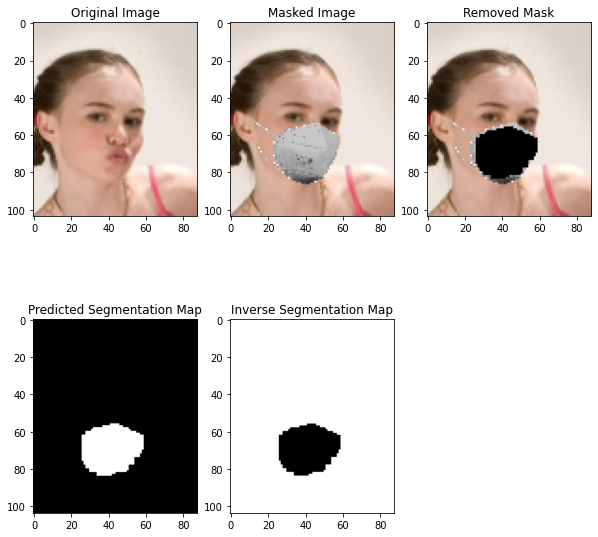

In [ ]:
figure = plt.figure(figsize=(10, 10))
rand_index = randint(0, DATASET_SIZE)

unmasked_img = figure.add_subplot(231)
plt.imshow(unmasked[rand_index])

masked_img = figure.add_subplot(232)
plt.imshow(masked[rand_index])

removed = figure.add_subplot(233)
plt.imshow((masked[rand_index] / 255) * (np.repeat(np.expand_dims(inverse_segmaps[rand_index], axis=-1), 3, axis=-1)))

segmap = figure.add_subplot(234)
plt.imshow(segmaps[rand_index], 'Greys_r')

inverse = figure.add_subplot(235)
plt.imshow(inverse_segmaps[rand_index], 'Greys_r')

unmasked_img.title.set_text('Original Image')
masked_img.title.set_text('Masked Image')
removed.title.set_text('Removed Mask')
segmap.title.set_text('Predicted Segmentation Map')
inverse.title.set_text('Inverse Segmentation Map')

Remove Masks

In [ ]:
removed_masks = []

for i in range(DATASET_SIZE):
    removed_masks.append(masked[i] * (np.repeat(np.expand_dims(inverse_segmaps[i], axis=-1), 3, axis=-1)) / 255)

In [ ]:
x = tf.convert_to_tensor(removed_masks)
y = tf.convert_to_tensor(np.array(unmasked) / 255)

# 90:10 Train-Test Split
test_start = (DATASET_SIZE * 9) // 10

train_data = tf.data.Dataset.from_tensors((x[:test_start], y[:test_start]))
test_data = tf.data.Dataset.from_tensors((x[test_start:], y[test_start:]))

In [ ]:
height = 104
width = 88
n_channels = 3
n_filters = 32

model = tf.keras.Sequential([
    tf.keras.layers.Input((height, width, n_channels)),

    # 104x88x3 -> 52x44x32
    tf.keras.layers.Conv2D(filters=n_filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.MaxPool2D((2, 2)),

    # 52x44x32 -> 26x22x64
    tf.keras.layers.Conv2D(filters=n_filters*2, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.BatchNormalization(),

    # 26x22x64 -> 13x11x128
    tf.keras.layers.Conv2D(filters=n_filters*4, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.BatchNormalization(),

    # 13x11x128 -> 13x11x256
    tf.keras.layers.Conv2D(filters=n_filters*8, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),

    # 13x11x256 -> 13x11x512
    tf.keras.layers.Conv2D(filters=n_filters*16, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),

    # 13x11x512 -> 26x22x256
    tf.keras.layers.Conv2DTranspose(filters=n_filters*8, kernel_size=(3, 3), strides=(2, 2), padding='same'),

    # 26x22x256 -> 52x44x128
    tf.keras.layers.Conv2DTranspose(filters=n_filters*4, kernel_size=(3, 3), strides=(2, 2), padding='same'),

    # 52x44x128 -> 104x88x64
    tf.keras.layers.Conv2DTranspose(filters=n_filters*2, kernel_size=(3, 3), strides=(2, 2), padding='same'),

    # 104x88x64 -> 104x88x32
    tf.keras.layers.Conv2DTranspose(filters=n_filters*1, kernel_size=(3, 3), strides=(1, 1), padding='same'),

    # 108x88x32 -> 108x88x3
    tf.keras.layers.Conv2D(filters=3, kernel_size=3, padding='same', kernel_initializer='he_normal')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 104, 88, 32)       896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 52, 44, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 52, 44, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 26, 22, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 26, 22, 64)       256       
 hNormalization)                                                 
                                                      

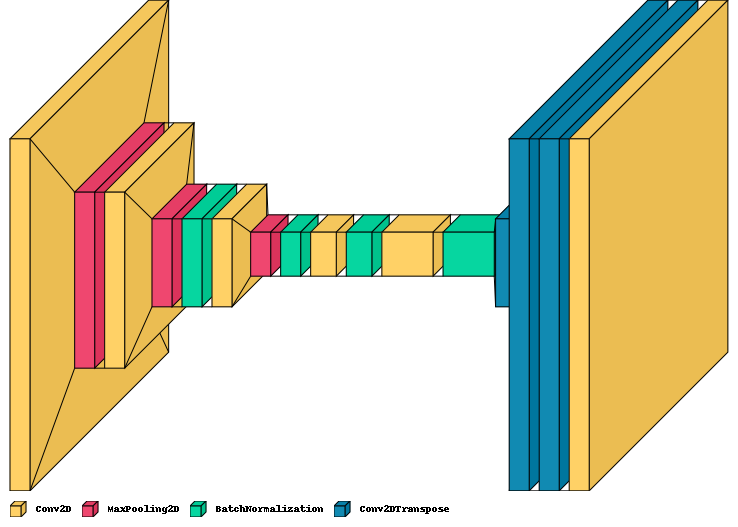

In [ ]:
visualkeras.layered_view(model, legend=True)

In [ ]:
def build_model(hp):
    model = tf.keras.Sequential([
        tf.keras.layers.Input((height, width, n_channels)),

        # 104x88x3 -> 52x44x32
        tf.keras.layers.Conv2D(filters=n_filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.MaxPool2D((2, 2)),

        # 52x44x32 -> 26x22x64
        tf.keras.layers.Conv2D(filters=n_filters*2, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.MaxPool2D((2, 2)),
        tf.keras.layers.BatchNormalization(),

        # 26x22x64 -> 13x11x128
        tf.keras.layers.Conv2D(filters=n_filters*4, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.MaxPool2D((2, 2)),
        tf.keras.layers.BatchNormalization(),

        # 13x11x128 -> 13x11x256
        tf.keras.layers.Conv2D(filters=n_filters*8, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.BatchNormalization(),

        # 13x11x256 -> 13x11x512
        tf.keras.layers.Conv2D(filters=n_filters*16, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.BatchNormalization(),

        # 13x11x512 -> 26x22x256
        tf.keras.layers.Conv2DTranspose(filters=n_filters*8, kernel_size=(3, 3), strides=(2, 2), padding='same'),

        # 26x22x256 -> 52x44x128
        tf.keras.layers.Conv2DTranspose(filters=n_filters*4, kernel_size=(3, 3), strides=(2, 2), padding='same'),

        # 52x44x128 -> 104x88x64
        tf.keras.layers.Conv2DTranspose(filters=n_filters*2, kernel_size=(3, 3), strides=(2, 2), padding='same'),

        # 104x88x64 -> 104x88x32
        tf.keras.layers.Conv2DTranspose(filters=n_filters*1, kernel_size=(3, 3), strides=(1, 1), padding='same'),

        # 108x88x32 -> 108x88x3
        tf.keras.layers.Conv2D(filters=3, kernel_size=3, padding='same', kernel_initializer='he_normal')
    ])
    model.compile(tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')), loss=tf.keras.losses.MSE)

    return model


In [ ]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.000605186189165695),
              loss=tf.keras.losses.MSE)

In [ ]:
# Tune Hyperparameters
if TUNE_HYPERPARAMETERS:
    import keras_tuner as kt
    tuner = kt.Hyperband(
        build_model,
        objective='loss',
        max_epochs=50,
        hyperband_iterations=2)

    tuner.search(train_data,
                epochs=10,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)])

In [ ]:
if TUNE_HYPERPARAMETERS:
    tuner.get_best_hyperparameters()[0].get('learning_rate')

In [ ]:
if TRAIN_MODEL:
    checkpoint = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH + '/inpainting_weights_unet_2500.h5', monitor='loss', save_best_only=True)
    history = model.fit(train_data, batch_size=16, epochs=2500, verbose=1, shuffle=True, callbacks=[checkpoint])
else:
    history = model.load_weights(CHECKPOINT_PATH + '/inpainting_weights_tuned_2500_0024.h5')

In [ ]:
if TRAIN_MODEL:
    plt.plot(history.history['loss'], label='Training Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

In [ ]:
whole_data = tf.data.Dataset.from_tensors((x, y))
outputs = model.predict(whole_data, batch_size=16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


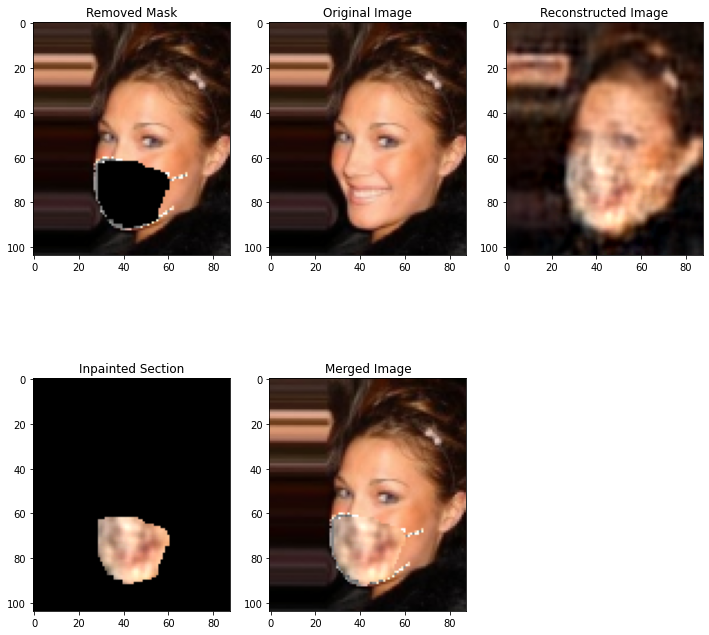

In [ ]:
index = 964

figure = plt.figure(figsize=(12, 12))

removed = figure.add_subplot(231)
plt.imshow(x[index])

expected = figure.add_subplot(232)
plt.imshow(y[index])

reconstructed = figure.add_subplot(233)
plt.imshow(outputs[index])

inpainted = figure.add_subplot(234)
inpainted_image = (outputs[index]) * (np.repeat(np.expand_dims(segmaps[index], axis=-1), 3, axis=-1))
plt.imshow(inpainted_image)

merged = figure.add_subplot(235)
plt.imshow(inpainted_image + x[index])

removed.title.set_text('Removed Mask')
expected.title.set_text('Original Image')
reconstructed.title.set_text('Reconstructed Image')
inpainted.title.set_text('Inpainted Section')
merged.title.set_text('Merged Image')

In [ ]:
f = h5py.File(BASE_PATH + 'ae_output.hdf5', 'w')
f.create_dataset('output', data=outputs)
f.close()

In [ ]:
model.save(MODEL_PATH)

INFO:tensorflow:Assets written to: /content/drive/My Drive/models/inpainting/assets
